```{eval-rst}
.. include:: sinebow.rst

```
{sinebow22}`Affinity segmentation`
==================================

This is the term that I think best describes encoding an image segmentation it its most general, information-dense form: an affinity graph. To explain what this is, we will first consider two cells in contact. 

{header-2}`The hierarchy of segmentation encoding`
--------------------------------------------------

In [1]:
%load_ext autoreload
%autoreload 2

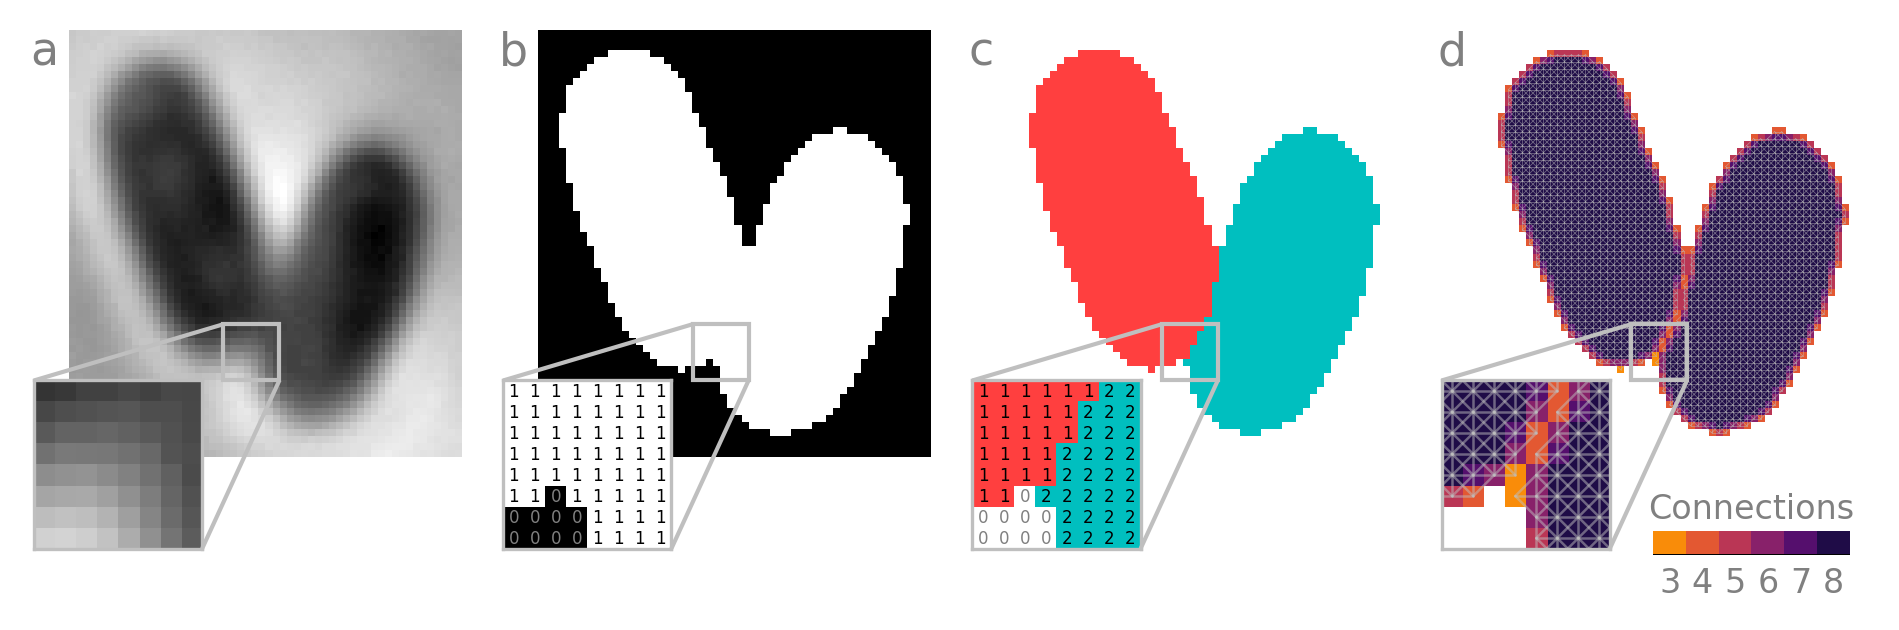

In [3]:
# Load image and masks
import string
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 600
# mpl.rcParams['facecolor'] = [0]*4

plt.rc('figure', facecolor=[0]*4)

plt.style.use('dark_background')
mpl.use('Agg')

%matplotlib inline

from pathlib import Path
import os
from cellpose_omni import io, plot
import fastremap

import omnipose
omnidir = Path(omnipose.__file__).parent.parent
basedir = os.path.join(omnidir,'docs','_static')
# name = 'ecoli_phase'
name = 'ecoli'
ext = '.tif'
image = io.imread(os.path.join(basedir,name+ext))
masks = io.imread(os.path.join(basedir,name+'_labels'+ext))
slc = omnipose.measure.crop_bbox(masks>0,pad=0)[0]
masks = fastremap.renumber(masks[slc])[0]
image = image[slc]

# Plot a few things 

import matplotlib.pyplot as plt
from omnipose.plot import apply_ncolor, plot_edges, imshow
from omnipose import utils
import numpy as np
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.patches import Patch



images = [image, masks>0, apply_ncolor(masks), masks>0] 
labels = ['Image\n(phase contrast)', 'Semantic\nsegmentation', 
          'Instance\nsegmentation', 'Affinity\nsegmentation']  

# Set up the figure and subplots
N = len(images)

f = 1
Y,X = masks.shape[-2:]
M = 1

h,w = masks.shape[-2:]

sf = w
p = 0.0035*w # needs to be defined as fraction of width for aspect ratio to work? 
h /= sf
w /= sf

# Calculate positions of subplots
left = np.array([i*(w+p) for i in range(N)])*1.
bottom = np.array([0]*N)*1.
width = np.array([w]*N)*1.
height = np.array([h]*N)*1.

max_w = left[-1]+width[-1]
max_h = bottom[-1]+height[-1]

sw = max_w
sh = max_h

sf = max(sw,sh)
left /= sw
bottom /= sh
width /= sw
height /= sh

# Create figure
s = 6
fig = plt.figure(figsize=(s,s*sh/sw), frameon=False, dpi=300)
# fig.patch.set_facecolor([0]*4)

# Add subplots
axes = []
for i in range(N):
    ax = fig.add_axes([left[i], bottom[i], width[i], height[i]])
    axes.append(ax)

# Iterate over each subplot and set the image, label, and formatting
c =  [0.5]*3
fontsize = 11

# bounds = [40,20,10,10]
bounds = [11,22,8,8]
h,w = masks.shape[-2:]
extent = np.array([0,w,0,h])#-0.5


sy,sx,wy,wx = bounds
zoomslc = tuple([slice(sy,sy+wy),slice(sx,sx+wx)])


cmap='inferno'

zoom = 3
# zoom, f = 5, 0.75
color = [.75]*3
edgecol = [1/3]*3
edgecol = [.75]*3+[.5]
axcol = [0.5]*3
# edgecol = [.5,.75,0]+[2/3]

lw= .2
labelpad = 3
fontsize2 = 8

do_labels = 0

for i, ax in enumerate(axes):

    # inset axes
    axins = zoomed_inset_axes(ax, zoom, loc='lower left',
                              bbox_to_anchor=(-wx/w,-2*wy/h), 
                              # bbox_to_anchor=(-wx/w*zoom/2,-zoom*wy/h), 
                              # bbox_to_anchor=(-f*zoom*wy/h,-f*wx/w*zoom), 
                              
                              
                              bbox_transform=ax.transAxes)
    
    if i==N-1:
        # ax.invert_yaxis()
        
        dim = masks.ndim
        shape = masks.shape
        steps, inds, idx, fact, sign = utils.kernel_setup(dim)
        coords = np.nonzero(masks) 
        affinity_graph = omnipose.core.masks_to_affinity(masks, coords, steps, 
                                                         inds, idx, fact, sign, dim)
        neighbors = utils.get_neighbors(coords,steps,dim,shape)
        summed_affinity, affinity_cmap = plot_edges(shape,affinity_graph,neighbors,coords,
                                                    figsize=1,fig=fig,ax=ax,extent=extent,
                                                    edgecol=edgecol,cmap=cmap,linewidth=lw
                                                   )
  
        
        axins.invert_yaxis()
        ax.invert_yaxis()
        
        summed_affinity, affinity_cmap = plot_edges(shape,affinity_graph,neighbors,coords,
                                            figsize=1,fig=fig,ax=axins,
                                            extent=extent,
                                            edgecol=edgecol,linewidth=lw*zoom,cmap=cmap, 
                                                    bounds=bounds
                                           )

        axins.set_xlim(zoomslc[1].start, zoomslc[1].stop)
        axins.set_ylim(h-zoomslc[0].start, h-zoomslc[0].stop)
        

        loc1,loc2 = 4,2
        patch, pp1, pp2 = mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec=color+[1],zorder=2)
        pp1.loc1 = 4
        pp1.loc2 = 1
        pp2.loc1 = 2
        pp2.loc2 = 3
        
        
        N = affinity_cmap.N
        colors = affinity_cmap.colors
  
        cax = inset_axes(ax, width="50%", height="100%", loc='lower right',
                 bbox_to_anchor=(-.05, -0.7, 1, 1), bbox_transform=ax.transAxes,
                 borderpad=0)

        # Display the color swatches as an image
        n = np.arange(3,9)
        Nc = len(n)
        cax.imshow(affinity_cmap(n.reshape(1,Nc)))#,vmin=n[0]-1,vmax=n[-1]+1)

        # Set the y ticks and tick labels
        cax.set_xticks(np.arange(Nc))
        nums = [str(i) for i in n]
        cax.set_xticklabels(nums,c=c,fontsize=fontsize2)
        cax.tick_params(axis='both', which='both', length=0, pad=labelpad)
        cax.set_yticks([])
        
        wa = .07
        ha = .05
        cax.set_aspect(ha/wa)
        cax.set_title('Connections',c=c,fontsize=fontsize2,pad=labelpad)
        for spine in cax.spines.values():
            spine.set_color(None)
    else:
        
        ax.imshow(images[i],cmap='gray',extent=extent)
        # axins.imshow(images[i][zoomslc],extent=extent,origin='upper')
        axins.imshow(images[i],extent=extent,cmap='gray')
        # axins.imshow(images[i])#,extent=extent)

        if i>0:
            imp = masks[::-1][zoomslc]
            if i==1:
                imp = imp>0
            for (j,k),label in np.ndenumerate(imp):
                axins.text(k+sx+0.5, j+sy+0.45, int(label), ha='center', va='center', color=[(label==0)*0.5]*3,fontsize=4)


        axins.set_xlim(zoomslc[1].start, zoomslc[1].stop)
        axins.set_ylim(zoomslc[0].start, zoomslc[0].stop)
     
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec=color+[1],zorder=2)
        
    
    if do_labels:
        ax.set_title(labels[i],c=c,fontsize=fontsize,fontweight="bold",pad=5)
    else:
        ax.annotate(string.ascii_lowercase[i], xy=(-0.1, 1), xycoords='axes fraction', 
        xytext=(0, 0), textcoords='offset points', va='top', c=axcol,
        fontsize=fontsize)
        
    ax.axis('off')  
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_facecolor([0]*4)

    for spine in axins.spines.values():
        spine.set_color(color)

        
# plt.subplots_adjust(wspace=0.15)
fig.patch.set_facecolor([0]*4)    

# Display the plot
plt.show()

In [53]:
datadir = omnidir.parent
file = os.path.join(datadir,'Dissertation','figures','hierarchy.pdf')
# file = os.path.join(datadir,'Dissertation','figures','hierarchy_pres.pdf')

if os.path.isfile(file): os.remove(file)
fig.savefig(file,transparent=True,pad_inches=.25,bbox_inches='tight')

Semantic segmentation sorts pixels into semantic classes. This is often just two classes, or binary classification: foreground and background. In this case, foreground is cell and background is media. As you can see, semantic segmentation does not discern between adjacent instances of foreground objects. We store a semantic segmentation as a binary image file with the same dimensions as the image itself, with foreground pixels labeled {py}`True` ({py}`1`) and background {py}`False` ({py}`0`). 

Instance segmentation assigns a unique integer to the pixels each instance of an object - in this case, each cell. This is also conveniently stored as an image file, typically uint8 (unsigned 8-bit integer) for up to $2^{8}-1=255$ labels or uint16 (unsigned 16-bit integer) for up to $2^{16}-1=65535$ labels. Signed and/or unsigned 32- or 64-bit formats may also be used, but your OS may not be able to preview these files in its native file manager. 

```{note}
Some instance labels use -1 as an "ignore" label. This can be in conflict with several tasks from indexing to label formatting, which assume unsigned integers, so care must be taken when working with signed formats (int) versus unsigned (uint). 
```


{header-2}`Bad labels I: Semantic islands to instance labels`
-------------------------------------------------------------
Semantic segmentation can be converted into instance segmentation, and this forms the basis of many instance segmentation pipelines. The general steps are:
1. Pre-process image: traditional filtering/blurring/feature extraction or DNN transformation 
2. Threshold processed image: adaptive techniques are usually used on the pre-processed image to ensure that the majority of objects pixels are identified despite variations within an image and among images in a dataset. Importantly, object boundaries **must not be identified** as foreground. This allows each object to be associated with a unique island of foreground pixels. 
3. These unique blobs are identified using **connected components labeling**. This is the process of building an affinity graph, where pixels are nodes and edges are formed between any adjacent foreground pixels. Adjacency can be defined most narrowly by sharing edges (1-connected in Python, 4-connected in MATLAB) or more broadly by sharing either edges or vertices (2-connected in Python, 8-connected in MATLAB). The graph is then traversed to find all connected components of the graph. 

These points are illustrated below. By simulating the amount of foreground pixels detected by filtering+thresholding, we see that is is impossible to distinguish between the two cells until much of the boundary is lost, particularly when using 2-connectivity. 

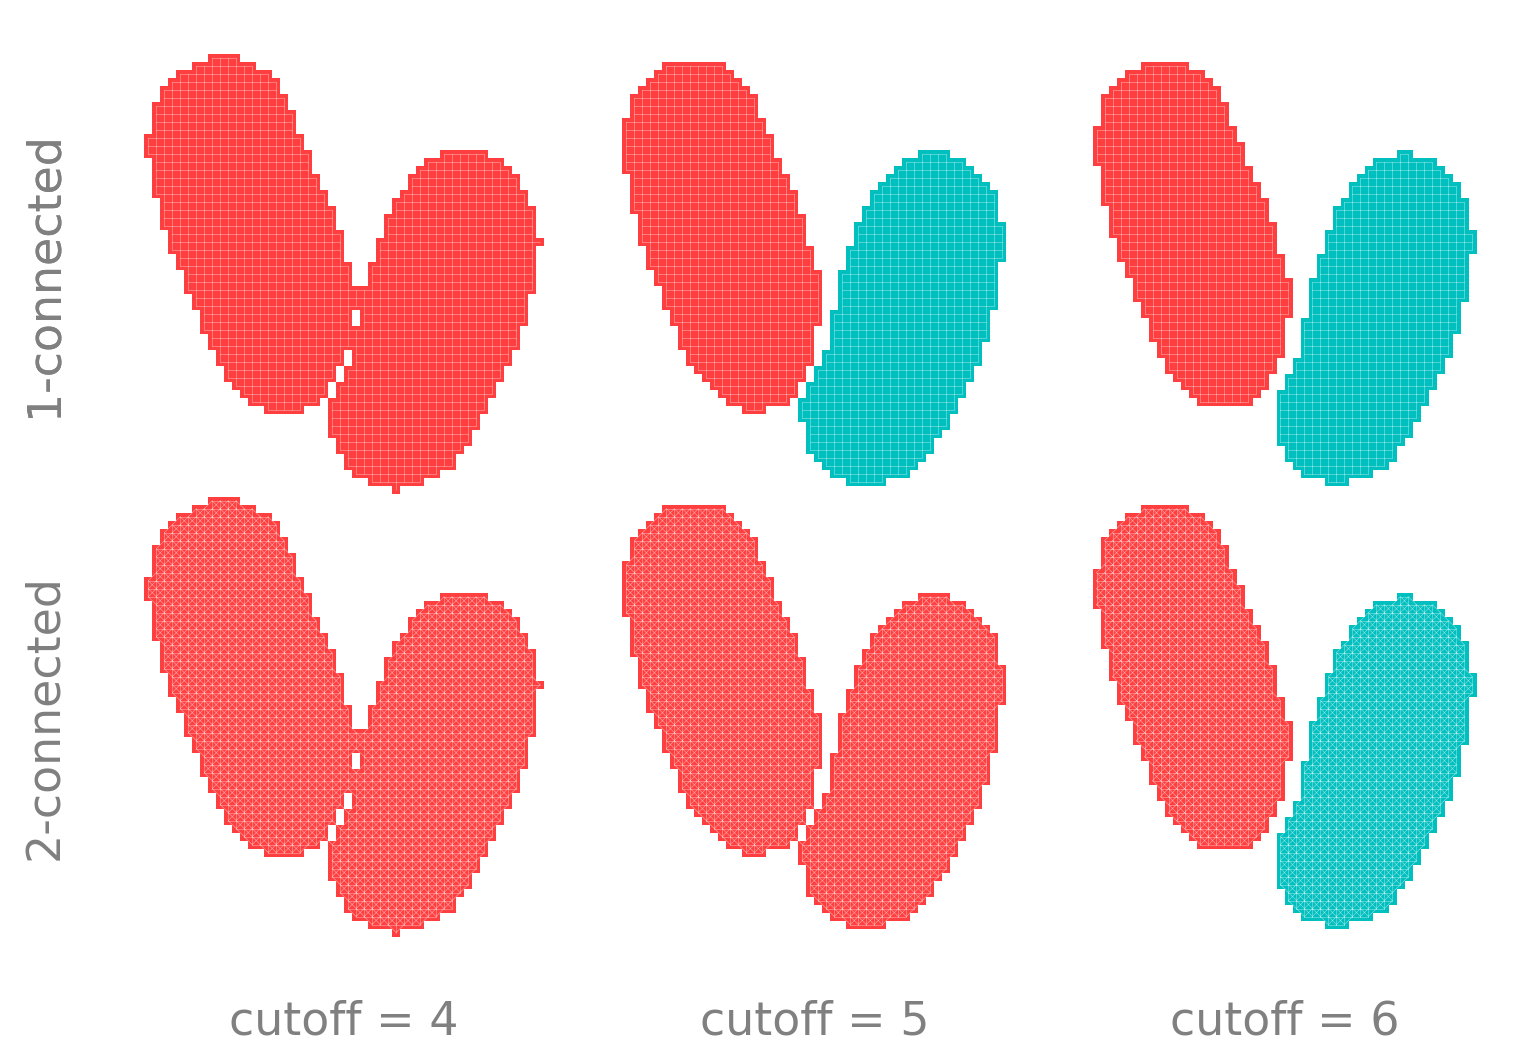

In [4]:
import skimage.measure

connectivity = [1,2]
cutoffs = [4,5,6]
row_labels = ['{}-connected'.format(i) for i in connectivity]
col_labels = ['cutoff = {}'.format(i) for i in cutoffs]
# Define the grid dimensions
num_rows = len(row_labels)
num_cols = len(col_labels)

# Create the grid of subplots

# f = .75
# dpi = mpl.rcParams['figure.dpi']
# Y,X = masks.shape[-2:]
# szX = max(X//dpi,2)*f
# szY = max(Y//dpi,2)*f
# fig, axes = plt.subplots(num_rows, num_cols,figsize=(szX*num_cols,szY*num_rows))




h,w = masks.shape[-2:]

sf = w
p = 0.05
h /= sf
w /= sf

# Calculate positions of subplots
N = num_cols
M = num_rows
left = np.array([5*p+i*(w+p) for i in range(N)]*M).flatten().astype(float)
# bottom = np.array([1.5*p]*N + [h+p]*N).flatten().astype(float)
bottom = np.array([h+p]*N+[3*p]*N).flatten().astype(float)
width = np.array([[w]*N]*M).flatten().astype(float)
height = np.array([[h]*N]*M).flatten().astype(float)

max_w = left[-1]+width[-1]
max_h = bottom[-1]+height[-1]

sw = max_w
sh = max_h

sf = max(sw,sh)
left /= sw
bottom /= sh
width /= sw
height /= sh

# Create figure
s = 5
fig = plt.figure(figsize=(s,s*sh/sw), frameon=False, dpi=300,facecolor=[0]*4)
# fig.patch.set_facecolor([0]*4)

# Add subplots
axes = []
for i in range(N*M):
    ax = fig.add_axes([left[i], bottom[i], width[i], height[i]])
    ax.set_facecolor([0]*4)
    
    axes.append(ax)


fig.patch.set_facecolor([0]*4)
color = [0.5]*3
# for row,conn in enumerate(connectivity):
#     for col,cutoff in enumerate(cutoffs):

for i,ax in enumerate(axes):
    row,col= np.unravel_index(i,(M,N))
    
    cutoff = cutoffs[col]
    conn = connectivity[row]
    
    
    bin0 = summed_affinity>cutoff
    msk0 = skimage.measure.label(bin0,connectivity=conn)
    pic = apply_ncolor(msk0)


    dim = masks.ndim
    shape = masks.shape
    steps, inds, idx, fact, sign = utils.kernel_setup(dim)
    coords = np.nonzero(msk0) 
    affinity_graph = omnipose.core.masks_to_affinity(msk0, coords, steps, 
                                                     inds, idx, fact, sign, dim)
    neighbors = utils.get_neighbors(coords,steps,dim,shape)

    #choose to plot cardinal connections only
    step_inds = None if conn==2 else inds[1]

    # index = np.ravel_multi_index([[row],[col]],(N,M))
    # ax = axes[row*col]
    ax.axis('off')
    
    # ax.text(0,0,i)

    plot_edges(shape,affinity_graph,neighbors,coords,figsize=1,extent=extent,
               fig=fig,ax=ax,step_inds=step_inds,pic=pic,origin='lower',edgecol=[1,1,1,0.5])

    ax.invert_yaxis()
    
    if i<N:
        ax.annotate(col_labels[i], xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad),
                xycoords=ax.xaxis.label, textcoords='offset points',
                ha='center', va='baseline',color=color,fontsize=fontsize)

    if i%M==0:
        ax.annotate(row_labels[row], xy=(0, 0), xytext=(-ax.yaxis.labelpad + 20, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='right', va='center', rotation=90,color=color,fontsize=fontsize)

plt.show()

In [259]:
datadir = omnidir.parent
fig.savefig(os.path.join(datadir,'Dissertation','figures','thresholding.pdf'),
    transparent=True,bbox_inches='tight')#,pad_inches=0)

Although such sloppy segmentation is good enough for some tasks, we have a better tools now. So in general, do not use image thresholding for segmentation. 


{header-2}`Bad labels II: Watershed lines`
------------------------------------------
While we are on the topic, missing boundary pixels also frequently arise when applying the watershed transform. As usually implemented, this ubiquitous operation returns a semantic classification of an image into watershed lines and catchment basins. As you can tell by the above example, this means that distinct basins must be separated by a 1- or 2-connected watershed line, and therefore boundary pixels are always left unclassified. 

There are implementations that allow users to return instance labels *without* the gaps let by watershed lines (*e.g.*, `skimage.segmentation.watershed`), but I have yet to see a paper published using this method. Despite this fix, watershed also tends to over-segment images (even when transformed by traditional filters or DNNs). So in general, do not use watershed for instance segmentation. 


{header-2}`Bad labels III: Self-contact boundaries`
---------------------------------------------------
Instance labels are good enough to fully describe a lot of objects. More precisely, there is a bijective map between the affinity graph and the instance label matrix whenever all edge pixels are in contact with a non-self pixel. This assumption fails in many interesting (and biologically relevant) scenarios, including bacterial microscopy. Consider the following image containing one extremely filamentous cell and corresponding cell mask:

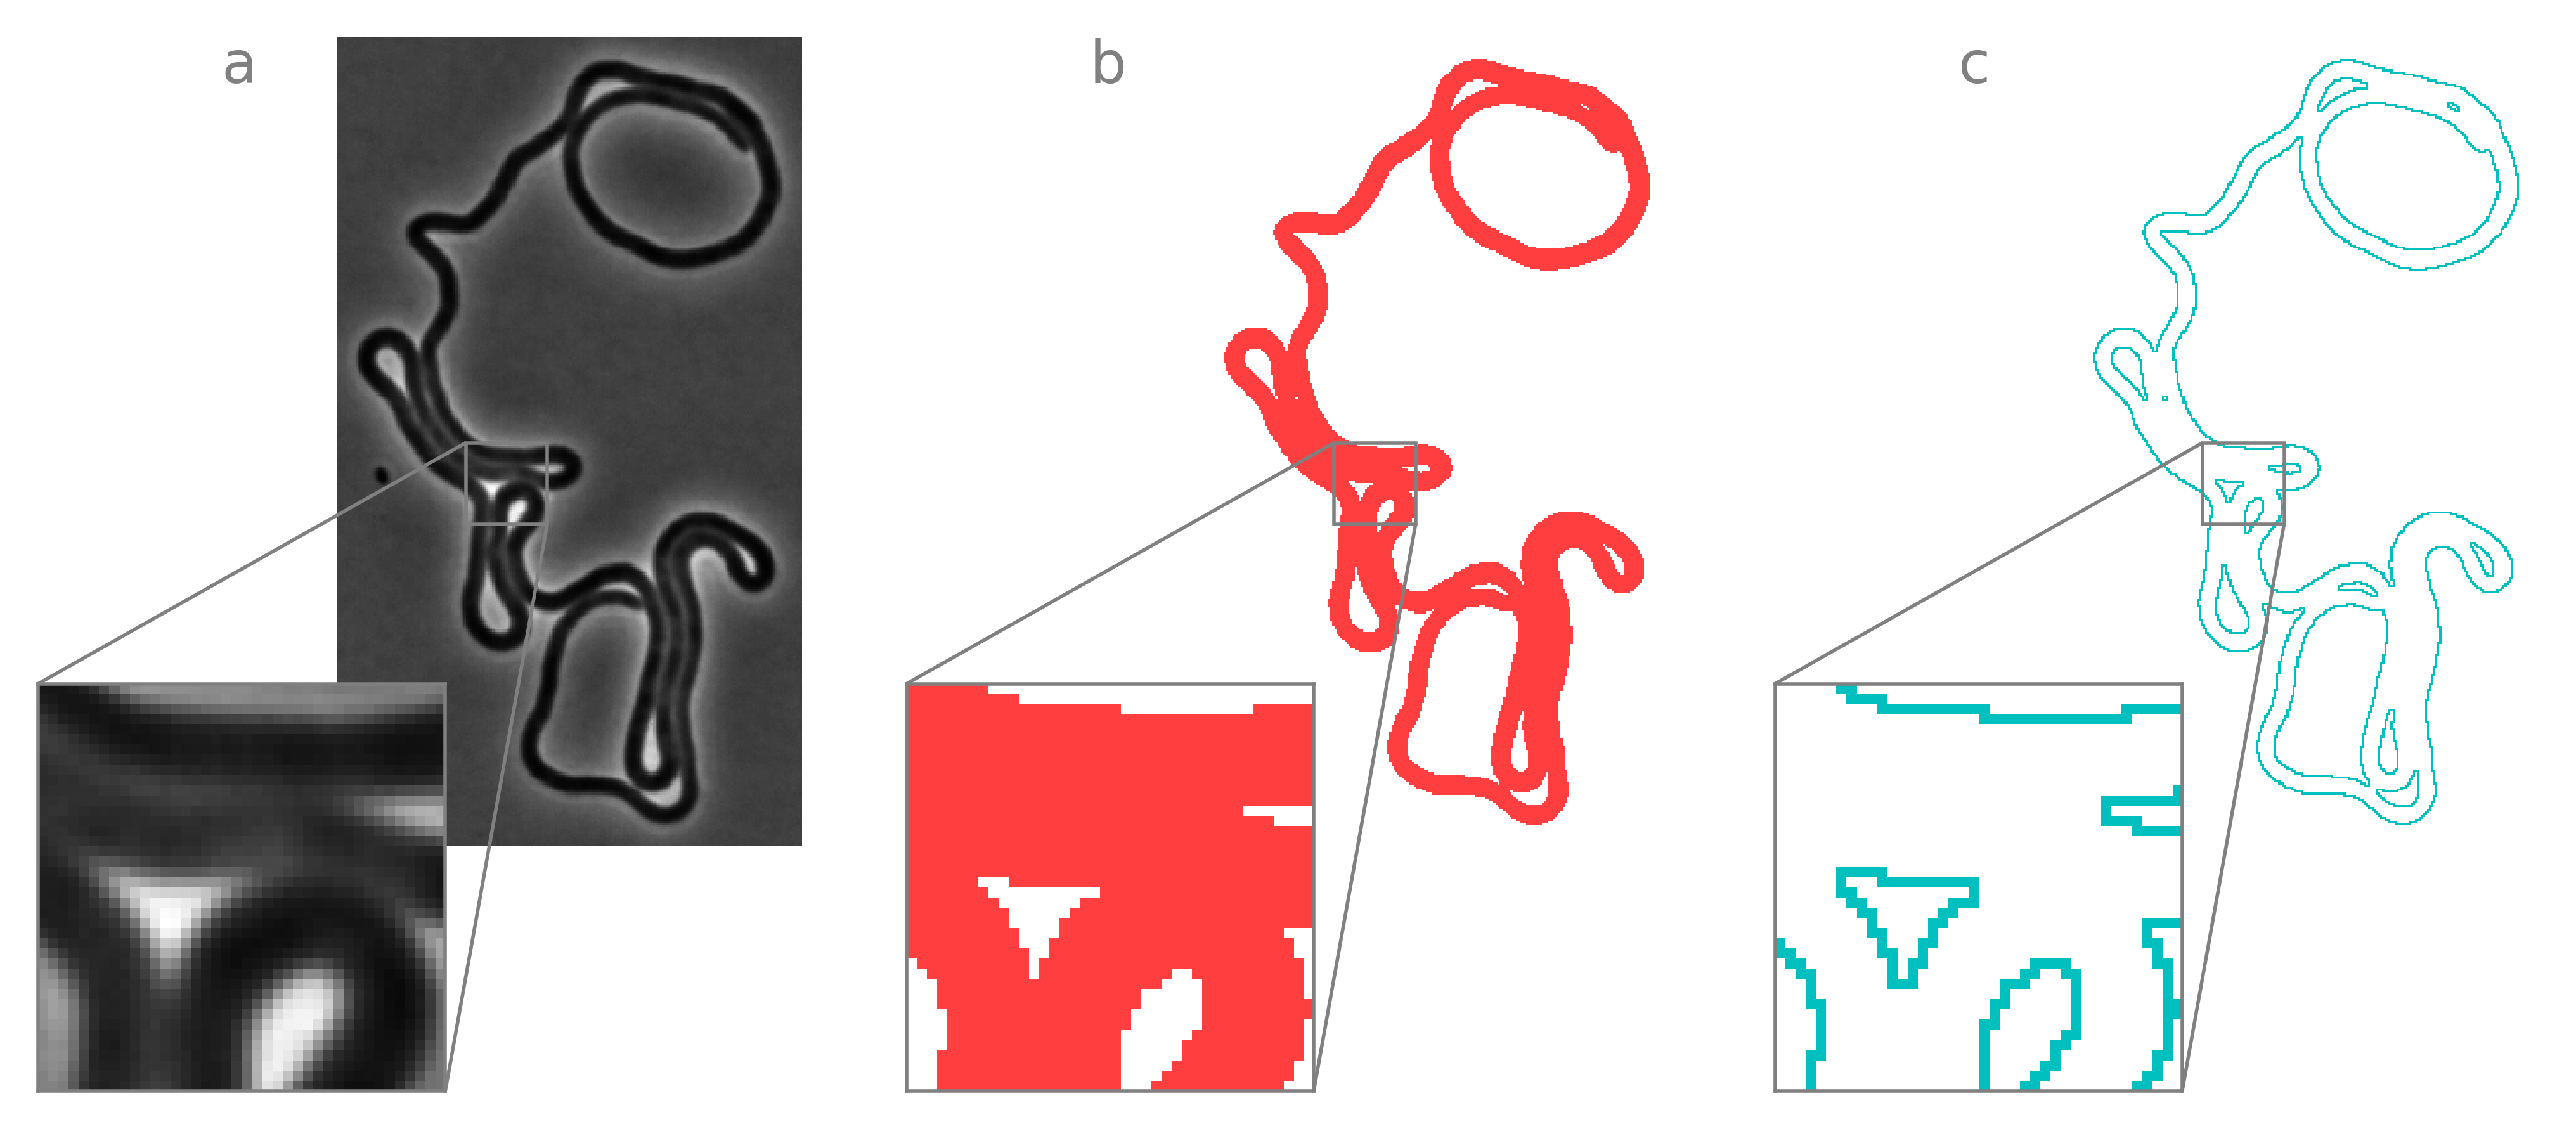

In [5]:
# read in files; this is an entire movie, but we will just be looking at the last frame 
import tifffile

nm = 'long_10_2'
masks = tifffile.imread(os.path.join(basedir,nm+'_op_masks.tif'))
phase = tifffile.imread(os.path.join(basedir,nm+'_phase.tif'))
fluor = tifffile.imread(os.path.join(basedir,nm+'_fluor.tif'))
afnty = utils.load_nested_list(os.path.join(basedir,nm+'_affinity.npz'))

# make figure
import omnipose, cellpose_omni
im = phase[-1]
msk = masks[-1]

f = 1
c = [0.5]*3
fontsize=11

titles = [r'$\bf{image}$'+'\n(phase contrast)', r'$\bf{label}$'+'\n(single cell mask)', r'$\bf{boundary}$'+'\n(from cell mask)']
ol = cellpose_omni.utils.masks_to_outlines(msk,omni=True)
# outlines = np.stack([ol]*4,axis=-1)*0.5
images = [im,
          omnipose.plot.apply_ncolor(msk),
          omnipose.plot.apply_ncolor(ol,offset=.5)]



# Set up the figure and subplots
N = len(images)
h,w = im.shape

sf = h
p = 0.5 # needs to be defined as fraction of width for aspect ratio to work? 


h,w = im.shape
extent = np.array([0,w,0,h])#-0.5
sy,sx,wy,wx = [h//2.5,w//3.6,40,40]
zoomslc = tuple([slice(sy,sy+wy),slice(sx,sx+wx)])
zoom = 5
bbox_to_anchor = (-(wx/w)*zoom/(1.25),-zoom/1.5*wy/h) # inset axis


asp = h/w

h /= sf
w /= sf

oy,ox = np.abs(bbox_to_anchor)/2
# oy,ox = 0.,0.
# Calculate positions of subplots
left = np.array([ox+i*(w+p) for i in range(N)])*1.
bottom = np.array([oy]*N)*1.
width = np.array([w]*N)*1.
height = np.array([h]*N)*1.

max_w = left[-1]+width[-1]+ox
max_h = bottom[-1]+height[-1]+oy

sw = max_w
sh = max_h

sf = max(sw,sh)
left /= sw
bottom /= sh
width /= sw
height /= sh

# Create figure
s = 6.5
fig = plt.figure(figsize=(s,s*sh/sw), frameon=False, dpi=600)
# fig.patch.set_facecolor([0]*4)

# Add subplots
axes = []
for i in range(N):
    ax = fig.add_axes([left[i], bottom[i], width[i], height[i]])
    axes.append(ax)
    
    

lwa = 2/N # linewidth for axes
lw = lwa/20 # linewidth for affinity graph
labelpad = 2

for i, ax in enumerate(axes):
    
    ax.imshow(images[i],cmap='gray',extent=extent)
    ax.axis('off')  
    
    
    
    # inset axes....
    # axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
    # axins = inset_axes(ax, 1,1 , loc=2, bbox_to_anchor=(.08, 0.35))
    axins = zoomed_inset_axes(ax, zoom, loc='lower left',
                              # bbox_to_anchor=(1.1, 1.1), 
                              # bbox_to_anchor=(-.15,-.15), 
                              bbox_to_anchor=bbox_to_anchor, 
                              bbox_transform=ax.transAxes)


   
    # axins.imshow(images[i][zoomslc],extent=extent,origin='upper')
    axins.imshow(images[i],extent=extent,cmap='gray')
    # axins.imshow(images[i])#,extent=extent)
    axins.set_xlim(zoomslc[1].start, zoomslc[1].stop)
    axins.set_ylim(zoomslc[0].start, zoomslc[0].stop)

    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec=color+[1], zorder=2, lw=lwa)
    # axins.axis('off')  
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_facecolor([0]*4)

    
    for spine in axins.spines.values():
        spine.set_color(color)
        spine.set_linewidth(lwa)

    
    if do_labels:
        # ax.set_title(labels[i],c=c,fontsize=fontsize,fontweight="bold",pad=5)
        ax.set_title(titles[i],c=c,fontsize=fontsize,pad=5)
        
    else:
        ax.annotate(string.ascii_lowercase[i], xy=(-0.25, 1), xycoords='axes fraction', 
        xytext=(0, 0), textcoords='offset points', va='top', c=axcol,
        fontsize=fontsize)
        

        
# plt.subplots_adjust(wspace=0,hspace=0)

# Display the plot
plt.show()

In [250]:
datadir = omnidir.parent
fig.savefig(os.path.join(datadir,'Dissertation','figures','selfcontact1.pdf'),
    transparent=True,bbox_inches='tight',pad_inches=0.05)

Because the label for this cell is the same integer on either side of a self-contact interface, we cannot localize the boundary of the cell at these interfaces. However, affinity segmentation encodes not only the information necessary to recontruct cell boundaries but also to traverse cell boundarues as a parametric contour. 

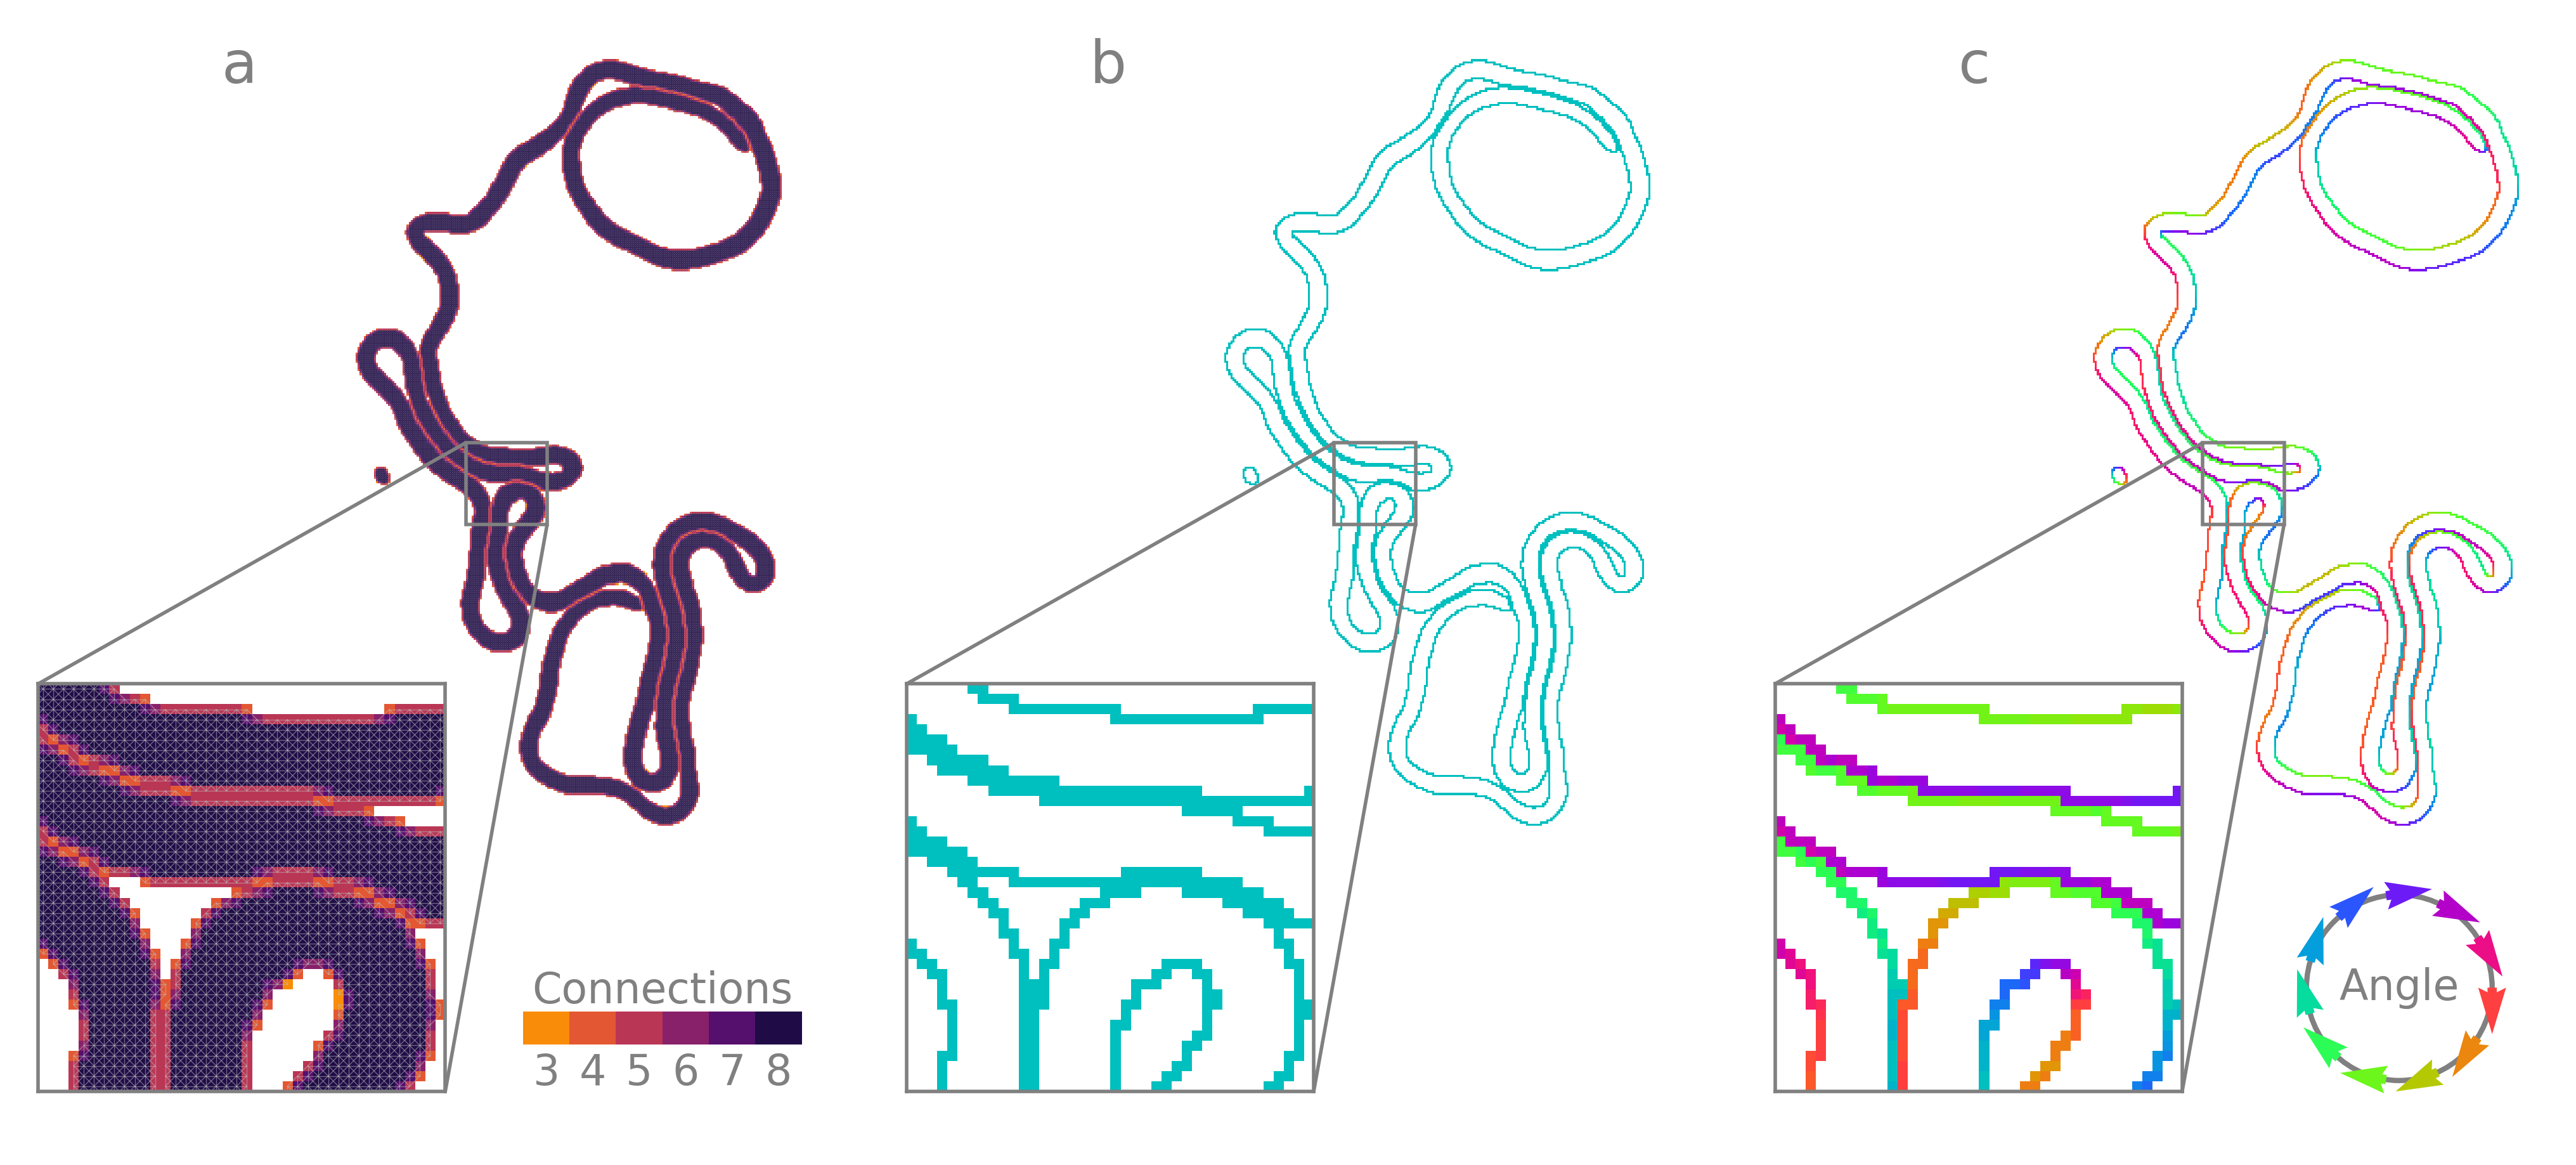

In [6]:
import omnipose, cellpose_omni
from scipy import signal
t = -1 # last frame
im = phase[t]
msk = masks[t]

f = 1
c = [0.5]*3
fontsize = 11

titles = [#r'$\bf{image}$'+'\n(phase contrast)', 
          r'$\bf{connectivity}$'+'\n(affinity graph)', 
          r'$\bf{boundary}$'+'\n(from affinity graph)',
          r'$\bf{contour}$'+'\n(traced with affinity)']

# extract the addinity graph and coordinate array 
aa = afnty[t]
shape = msk.shape
dim = msk.ndim
neighbors = aa[:dim]
affinity_graph = aa[dim]#.astype(bool) #VERY important to cast to bool, now done internally 
idx = affinity_graph.shape[0]//2
coords = tuple(neighbors[:,idx])

# make the boundary
ol = omnipose.core.affinity_to_boundary(msk,affinity_graph,coords)

# make the contour
contour_map, contour_list, unique_L = omnipose.core.get_contour(msk,affinity_graph,coords,cardinal_only=1)

cmap='inferno'
color = [0.5]*3



# contour_colored = np.stack([(contour_map>1).astype(np.float32)]*4,axis=-1)
contour_colored = np.zeros(contour_map.shape+(4,))

for contour in contour_list:
    # coords_t = np.unravel_index(contour,contour_map.shape)
    coords_t = np.stack([c[contour] for c in coords])
    cyclic_diff = np.diff(np.append(coords_t, coords_t[:, 0:1], axis=1), axis=1)

    a = cyclic_diff
    window_size = 11
    window = np.ones(window_size) / window_size
    cyclic_diff = signal.convolve2d(np.concatenate((a[:, -window_size+1:], a, a[:, :window_size-1]), axis=1), np.expand_dims(window, axis=0), mode='same')[:, window_size-1:-window_size+1]

    angles = np.arctan2(cyclic_diff[1], cyclic_diff[0])+np.pi


    a = 2
    r = ((np.cos(angles)+1)/a)
    g = ((np.cos(angles+2*np.pi/3)+1)/a)
    b =((np.cos(angles+4*np.pi/3)+1)/a)
    
    rgb = np.stack((r,g,b,np.ones_like(angles)),axis=-1)
    
    # v = np.array(range(len(contour)))/len(contour)
    # contour_colored[tuple(coords_t)] = ctr_cmap(v)
    contour_colored[tuple(coords_t)] = rgb


images = [#im,
          None,
          omnipose.plot.apply_ncolor(ol,offset=.5),
          contour_colored]

# N = len(images)
# A = N//2
# B = N-A

# fig, axes = plt.subplots(2,B, figsize=(szX*A,szY*B))  
# fig.patch.set_facecolor([0]*4)

# inset axis


# Set up the figure and subplots
N = len(images)
h,w = im.shape


extent = np.array([0,w,0,h])#-0.5
sy,sx,wy,wx = [h//2.5,w//3.6,40,40]
zoomslc = tuple([slice(sy,sy+wy),slice(sx,sx+wx)])
zoom = 5
bbox_to_anchor = (-(wx/w)*zoom/(1.25),-zoom/1.5*wy/h)
asp = h/w

sf = h
p = 0.5 # needs to be defined as fraction of width for aspect ratio to work? 
h /= sf
w /= sf

oy,ox = np.abs(bbox_to_anchor)/2
# oy,ox = 0.,0.
# Calculate positions of subplots
left = np.array([ox+i*(w+p) for i in range(N)])*1.
bottom = np.array([oy]*N)*1.
width = np.array([w]*N)*1.
height = np.array([h]*N)*1.

max_w = left[-1]+width[-1]+ox
max_h = bottom[-1]+height[-1]+oy

sw = max_w
sh = max_h

sf = max(sw,sh)
left /= sw
bottom /= sh
width /= sw
height /= sh

# Create figure
s = 6.5
fig = plt.figure(figsize=(s,s*sh/sw), frameon=False, dpi=600)

# Add subplots
axes = []
for i in range(N):
    ax = fig.add_axes([left[i], bottom[i], width[i], height[i]])
    axes.append(ax)
    


h,w = im.shape


lwa = 2/N # linewidth for axes
lw = lwa/20 # linewidth for affinity graph
labelpad = 4/3

fontsize2 = 8

for i, ax in enumerate(axes):
    
    # inset axes....
    # axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
    # axins = inset_axes(ax, 1,1 , loc=2, bbox_to_anchor=(.08, 0.35))
    axins = zoomed_inset_axes(ax, zoom, loc='lower left',
                              # bbox_to_anchor=(1.1, 1.1), 
                              # bbox_to_anchor=(-.15,-.15), 
                              bbox_to_anchor=bbox_to_anchor, 
                              bbox_transform=ax.transAxes)

    if i==(N-3):
        # ax.invert_yaxis()
        neighbors = utils.get_neighbors(coords,steps,dim,shape)
        
        # plot the while affinity graph
        summed_affinity, affinity_cmap = plot_edges(shape,affinity_graph,neighbors,coords,
                                                    figsize=1,fig=fig,ax=ax,extent=extent,
                                                    edgecol=edgecol,cmap=cmap,linewidth=lw

                                                   )
  
        # plot the inset one 
        axins.invert_yaxis()
        ax.invert_yaxis()
        
        summed_affinity, affinity_cmap = plot_edges(shape,affinity_graph,neighbors,coords,
                                            figsize=1,fig=fig,ax=axins,
                                            extent=extent,
                                            edgecol=edgecol,linewidth=lw*zoom,cmap=cmap
                                           )

        # axins.set_xlim(zoomslc[1].start, zoomslc[1].stop)
        axins.set_xlim(zoomslc[1].start, zoomslc[1].stop)
        
        # axins.set_ylim(zoomslc[0].stop, zoomslc[0].start)
        # axins.set_ylim(h-zoomslc[0].stop, h-zoomslc[0].start)
        axins.set_ylim(h-zoomslc[0].start, h-zoomslc[0].stop)
        

        loc1,loc2 = 4,2
        patch, pp1, pp2 = mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", 
                                     ec=color+[1],zorder=2,lw=lwa)
        pp1.loc1 = 4
        pp1.loc2 = 1
        pp2.loc1 = 2
        pp2.loc2 = 3
        
        


        # Display the color swatches as an image
        Nc = affinity_cmap.N
        colors = affinity_cmap.colors
  
        wa = .07
        ha = .05
        # cax = fig.add_axes([.3975, -.08, wa, ha])
        cax = inset_axes(ax, width="60%", height="100%", loc='lower right',
                 bbox_to_anchor=(0, -0.725, 1, 1), bbox_transform=ax.transAxes,
                 borderpad=0)
        
        n = np.arange(3,9)
        Nc = len(n)
        cax.imshow(affinity_cmap(n.reshape(1,Nc)))#,vmin=n[0]-1,vmax=n[-1]+1)

        # Set the y ticks and tick labels
        # cax.set_yticks(np.arange(N))
        cax.set_xticks(np.arange(Nc))
        
        nums = [str(i) for i in n]
        cax.set_xticklabels(nums,c=c,fontsize=fontsize2)
        cax.tick_params(axis='both', which='both', length=0, pad=labelpad)
        cax.set_yticks([])
        
        wa = .07
        ha = .05
        cax.set_aspect(ha/wa)
        cax.set_title('Connections',c=c,fontsize=fontsize2, pad=labelpad)
        for spine in cax.spines.values():
            spine.set_color(None)
            
        # cax.xaxis.set_labelpad  = -10
    else:



        ax.imshow(images[i],cmap='gray',extent=extent)
        # axins.imshow(images[i][zoomslc],extent=extent,origin='upper')
        axins.imshow(images[i],extent=extent,cmap='gray')
        # axins.imshow(images[i])#,extent=extent)
        axins.set_xlim(zoomslc[1].start, zoomslc[1].stop)
        axins.set_ylim(zoomslc[0].start, zoomslc[0].stop)

        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", 
                   ec=color+[1], zorder=2, lw=lwa)
        
        
        
    if i==(N-1):
        # ax2 = fig.add_axes([.7, -.15, .25, .25])
        ax2 = inset_axes(ax, width="60%", height="100%", loc='lower right',
             bbox_to_anchor=(0, -0.675, 1, 1), bbox_transform=ax.transAxes,
             borderpad=0)
        lw2 = 1

        # Create the circle and arrows on the second subplot
        circle = plt.Circle((0, 0), 1, fill=False, edgecolor=c,lw=lw2)
        ax2.add_artist(circle)

        # Set the number of arrows and colormap
        n_arrows = 11
        cmap = plt.get_cmap('hsv')

        for j in range(n_arrows):
            angle = j * 2 * np.pi / n_arrows
            a = 2
            r = ((np.cos(angle)+1)/a)
            g = ((np.cos(angle+2*np.pi/3)+1)/a)
            b =((np.cos(angle+4*np.pi/3)+1)/a)

            rgb = np.stack((r,g,b,np.ones_like(angle)),axis=-1)

            
            x, y = np.cos(angle), np.sin(angle)
            # dx, dy = -y, x
            dx, dy = y,-x
            
            # clr = cmap(j / n_arrows)
            ax2.quiver(x, y, dx, dy, color=rgb, angles='xy', scale_units='xy', scale=2, width=.05)

        # Add text to the center of the circle
        ax2.text(0, 0, 'Angle', ha='center', va='center',c=c,fontsize=fontsize2)

        # Set the axis limits and aspect ratio
        ax2.set_xlim(-1.5, 1.5)
        ax2.set_ylim(-1.5, 1.5)
        ax2.set_aspect('equal')

        # Remove the axes from the second subplot
        ax2.axis('off')    
    
    
    if do_labels:
        # ax.set_title(labels[i],c=c,fontsize=fontsize,fontweight="bold",pad=5)
        ax.set_title(titles[i],c=c,fontsize=fontsize,pad=5)
        
    else:
        ax.annotate(string.ascii_lowercase[i], xy=(-0.25, 1), xycoords='axes fraction', 
        xytext=(0, 0), textcoords='offset points', va='top', c=axcol,
        fontsize=fontsize)
        
    
    
    ax.axis('off')  
    # axins.axis('off')  
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_facecolor([0]*4)

    
    for spine in axins.spines.values():
        spine.set_color(color)
        spine.set_linewidth(lwa)

        
# plt.subplots_adjust(wspace=-0,hspace=0)
plt.subplots_adjust(wspace=-.35,hspace=.5)


# Display the plot
plt.show()

In [48]:
datadir = omnidir.parent
fig.savefig(os.path.join(datadir,'Dissertation','figures','selfcontact2.pdf'),
    transparent=True,bbox_inches='tight',pad_inches=0.05)

Pixels (or in ND, hypervoxels) may be classified as interior or boundary by their net connectivity. An ND hypervoxel connected to all $3^{N}-1$ neighbors is classified as **internal** (8 in 2D, fully 2-connected to both cardinal and ordinal neighbors). Hypervoxels with fewer than $3^{N}-1$ connections are classified as **boundary**. In Omnipose, hypervoxels with fewer than $N$ connections are pruned when using affinity segmentation to avoid spurs and allow cell contours in 2D to be traced. 

Because connections in an affinity graph are symmetrical, interfaces between objects are 2 hypervoxels thick. That is, the shortest path between the interiors of any two objects will pass through at least two boundary hypervoxels, one belonging to each object. Thresholding-based methods of boundary detection do not guarantee this symmetry and thus predict too many or too few boundary hypervoxels. 